In [39]:
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Tuple, Dict, List

# Schema
UNIX_TIMESTAMP_COL = 'Timestamp'
USER_ID_COL = 'User'
ROUTE_COL = 'Route'

In [2]:
rawdata = pd.read_csv('gs://anomaly_detection_inputs/saltdsassignment/data.csv.zip')
rawdata.Timestamp = rawdata.Timestamp.astype(int) 
rawdata['date_timestamp'] = pd.to_datetime(rawdata.Timestamp, unit='s')

# Set time intervals

In [13]:
def generate_time_intervals(unix_start_time: int, unix_end_time: int, 
                            time_interval: int) -> Dict[int, int]:
    """
    This function generate time intervals (by seconds) ranges by the user specific request
    """
    still_remain = True
    
    alternative_time: Dict[int, int] = dict()
    lower_boundry = unix_start_time
    
    while still_remain:
        upper_boundry = lower_boundry + time_interval
        mean_value = lower_boundry + math.ceil(0.5*time_interval)
        
        for unix_second in range(lower_boundry, upper_boundry):
            alternative_time[unix_second] = mean_value
        
        if upper_boundry > unix_end_time:
            still_remain = False
        
        else:
            lower_boundry = upper_boundry
            
    return alternative_time


def set_time_intervals(rawdata: pd.DataFrame, time_intervals_list: List[int]) -> pd.DataFrame:
    """
    This function add column with an alternative timestamps value according to each of the intervlas 
    windows provided in the time_intervals list
    """
    unix_start_time = rawdata[UNIX_TIMESTAMP_COL].min()
    unix_end_time = rawdata[UNIX_TIMESTAMP_COL].max()
    
    for time_interval in time_intervals_list:
        time_intervals = generate_time_intervals(unix_start_time, unix_end_time, 
                            time_interval)
        
        rawdata[f'interval_window_{time_interval}_sec'] = rawdata[UNIX_TIMESTAMP_COL].map(
            time_intervals)
        
    return rawdata

%time rawdata = set_time_intervals(rawdata, [10, 30, 60, 180, 300])

CPU times: user 3.76 s, sys: 292 ms, total: 4.05 s
Wall time: 4.05 s


# Routes Analysis

### Analyze the number of requests to a route

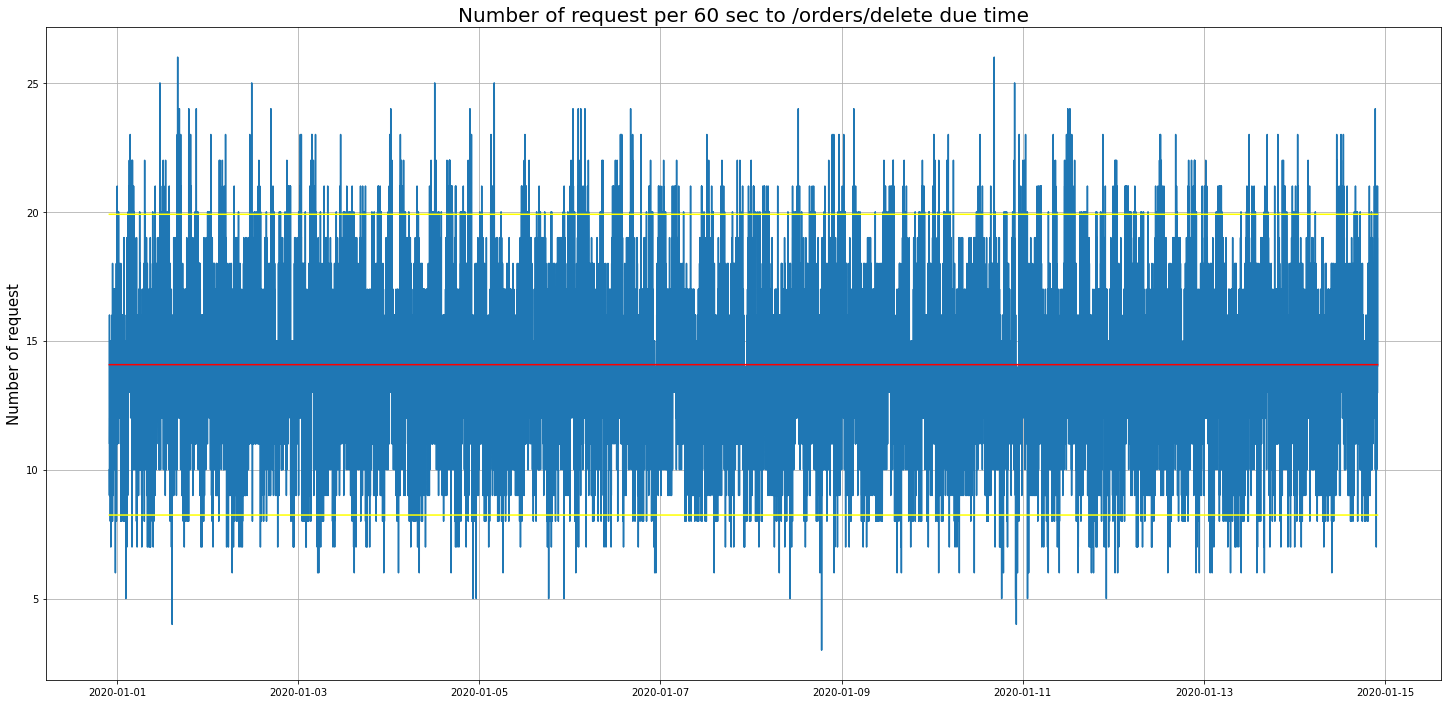

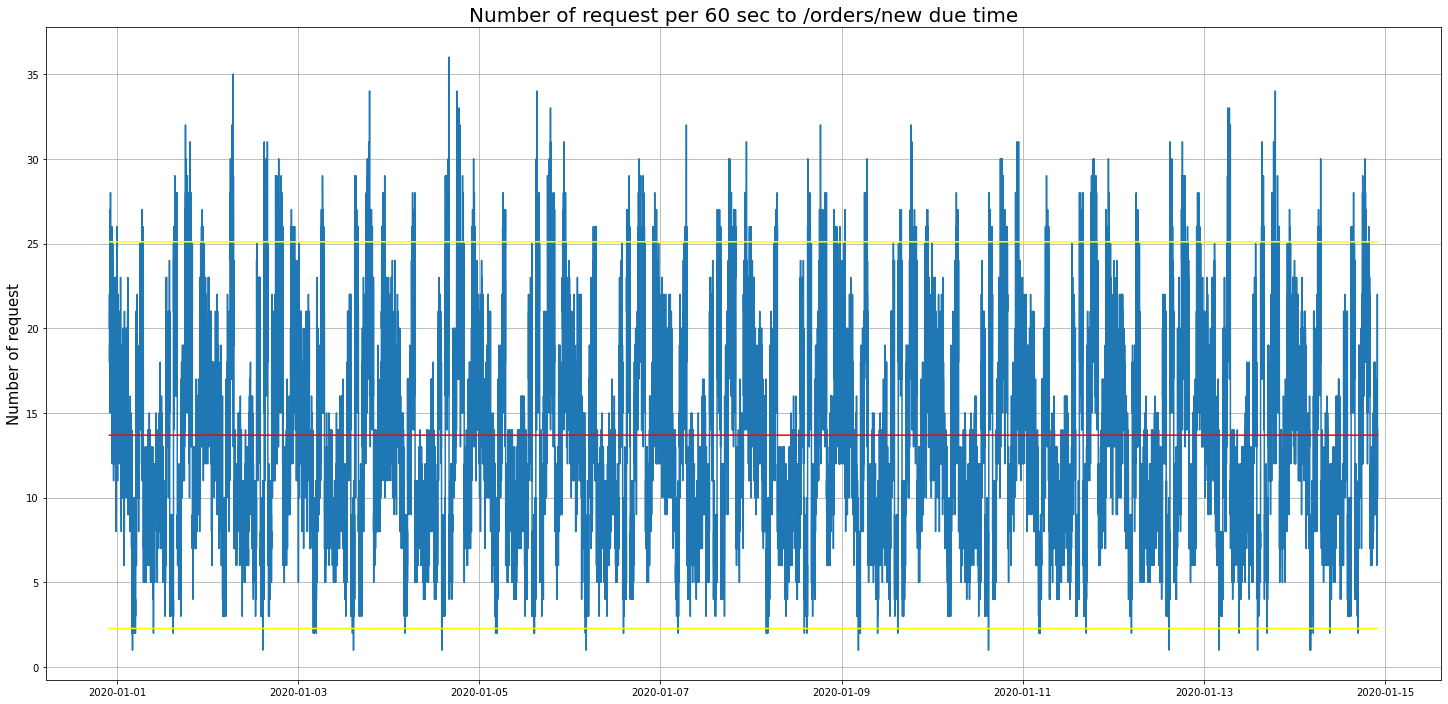

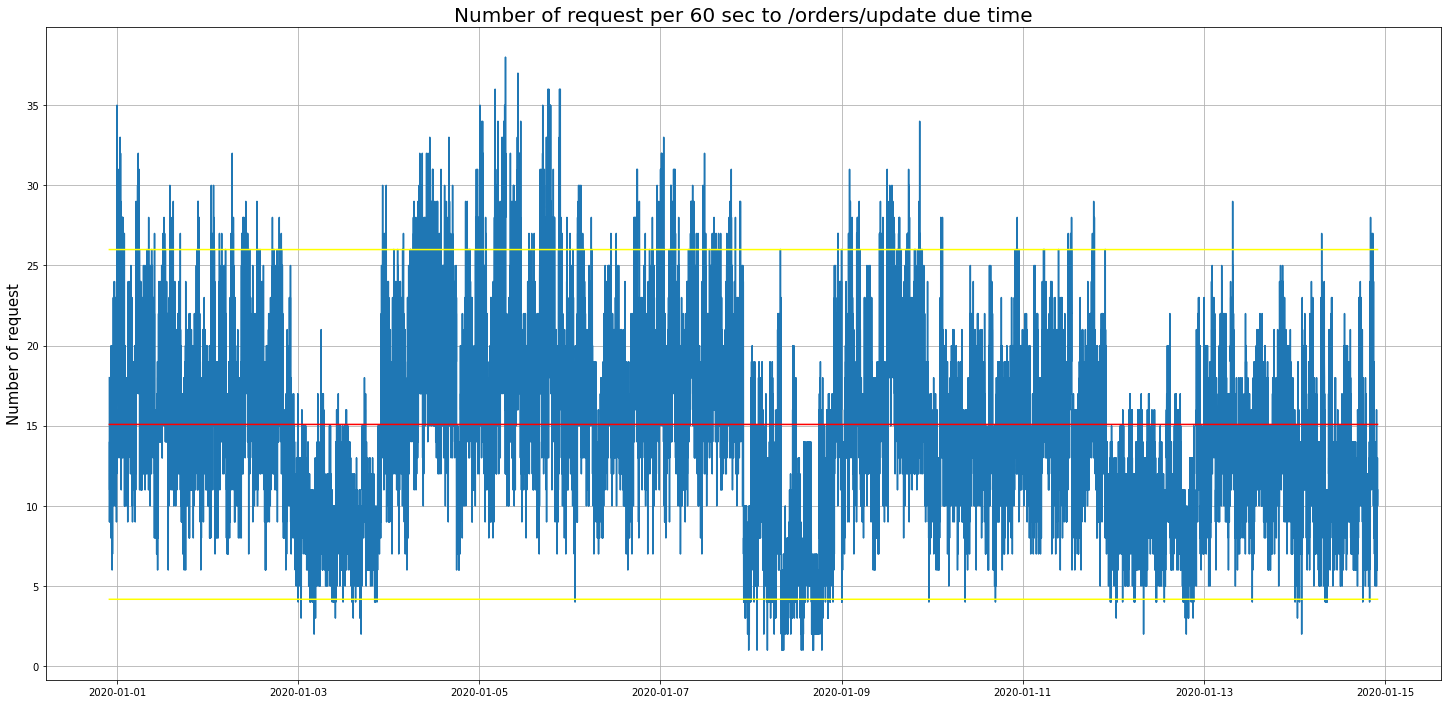

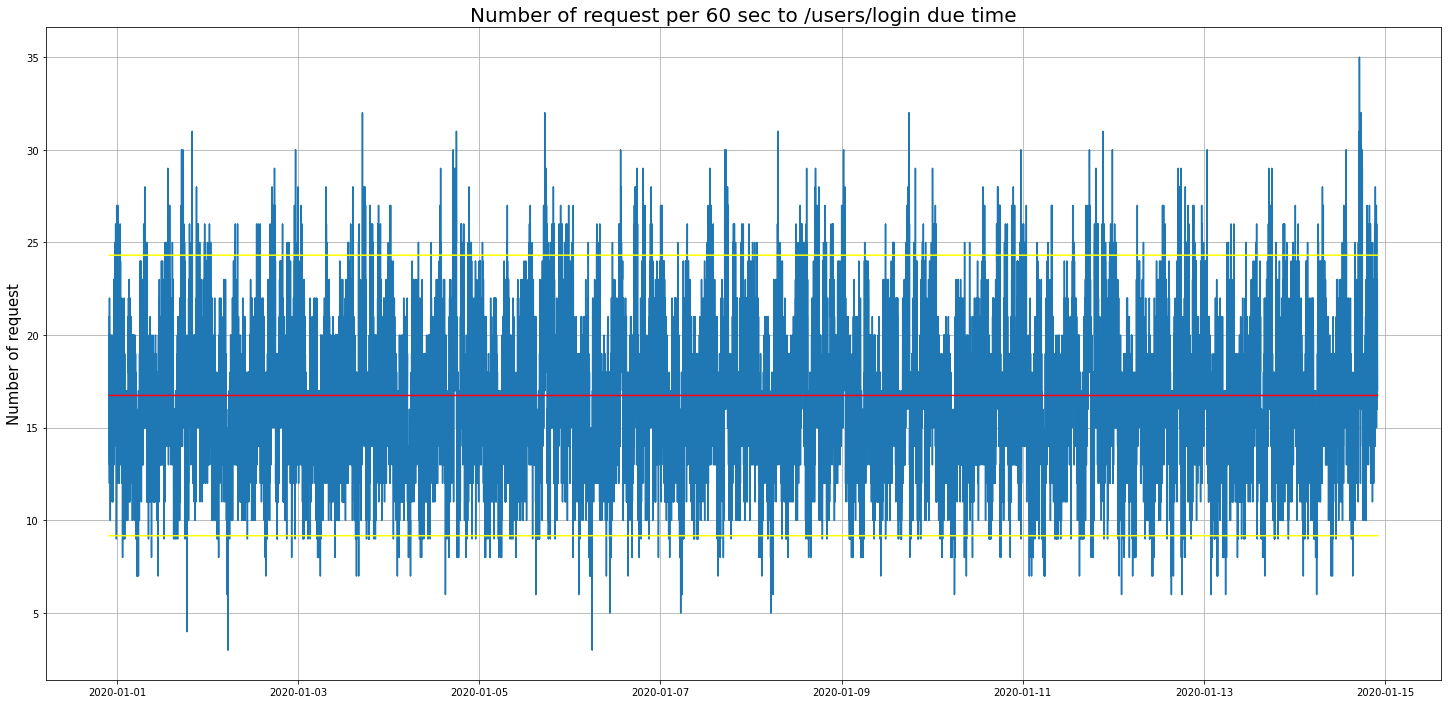

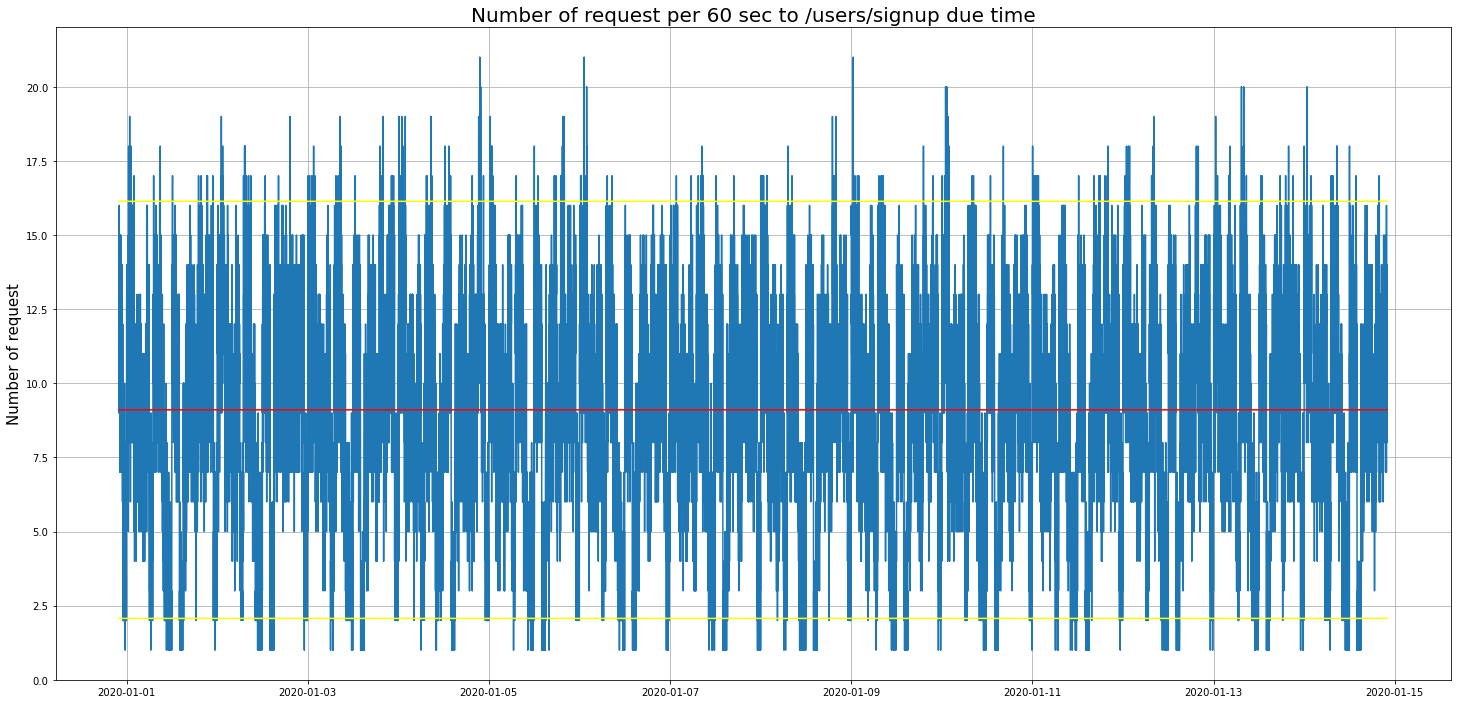

In [48]:
for route, route_data in rawdata.groupby('Route'):
    temp_agg_df = route_data['interval_window_60_sec'].value_counts().reset_index()
    temp_agg_df['time'] = pd.to_datetime(temp_agg_df['index'], unit='s')
    temp_agg_df.sort_values(by='time', inplace=True)
    avrage_request = np.mean(temp_agg_df.interval_window_60_sec)
    std_request = np.std(temp_agg_df.interval_window_60_sec)
    plt.figure(figsize=(25,12))
    plt.grid()
    plt.plot(temp_agg_df.time, temp_agg_df.interval_window_60_sec)
    plt.plot(temp_agg_df.time, [avrage_request]*temp_agg_df.shape[0], color='red')
    plt.plot(temp_agg_df.time, [avrage_request+std_request*1.96]*temp_agg_df.shape[0], color='yellow')
    plt.plot(temp_agg_df.time, [avrage_request-std_request*1.96]*temp_agg_df.shape[0], color='yellow')
    plt.ylabel('Number of request', fontsize=15)
    plt.title(f'Number of request per 60 sec to {route} due time', fontsize=20)
    plt.show()

### Analyze the number of unique users generate API request to a route 

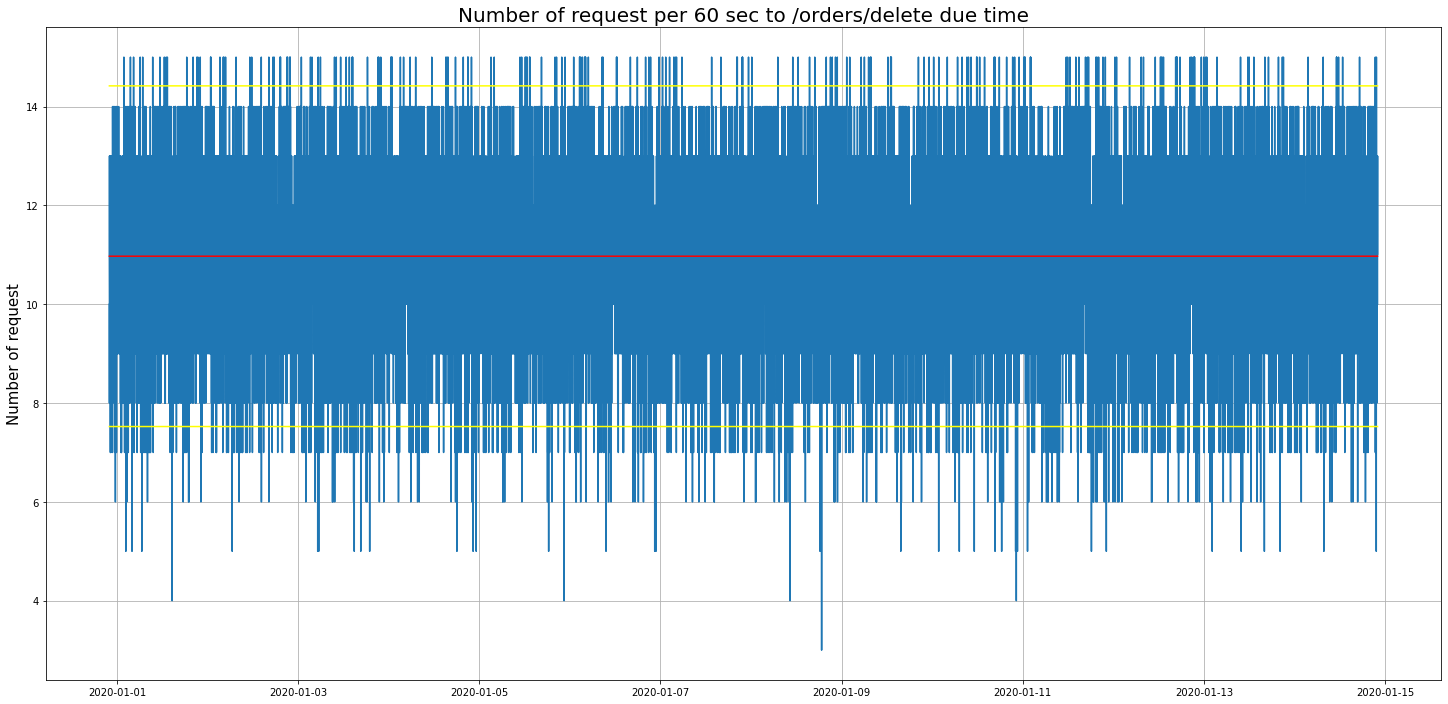

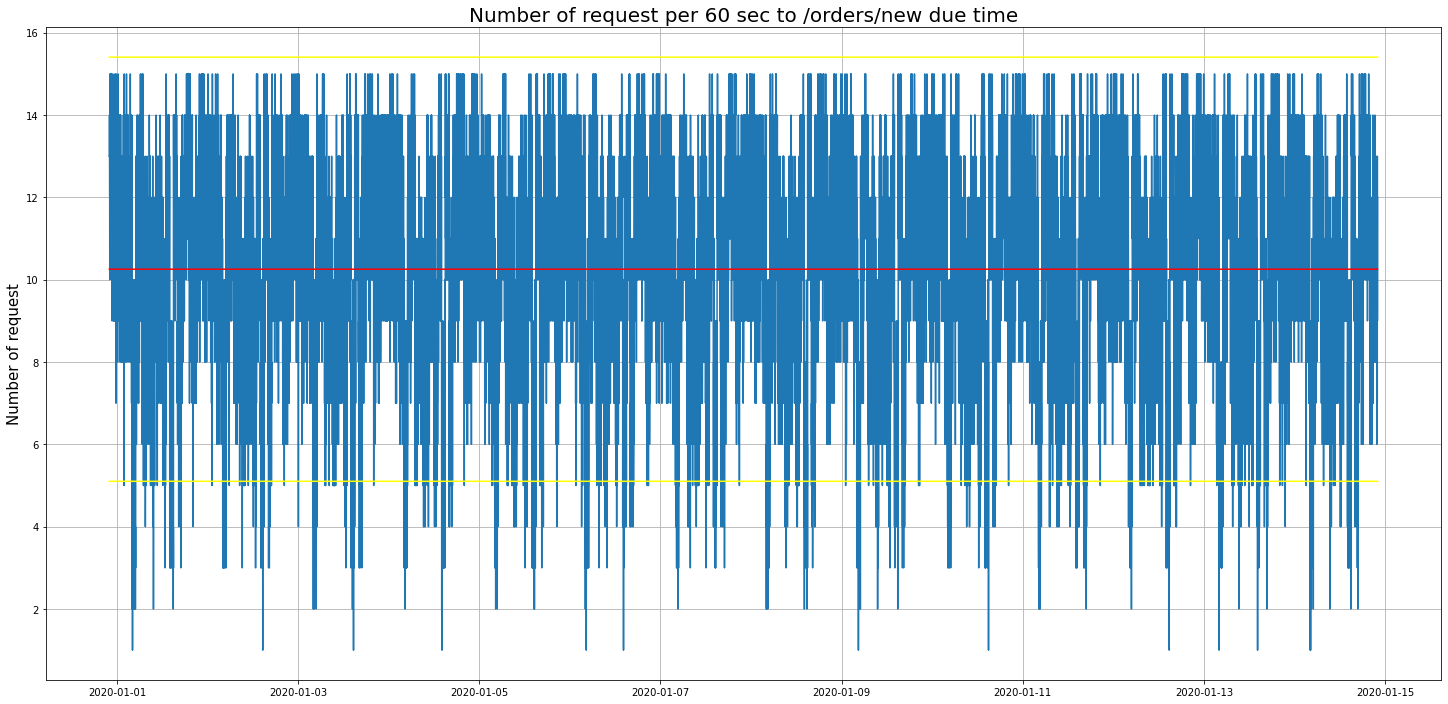

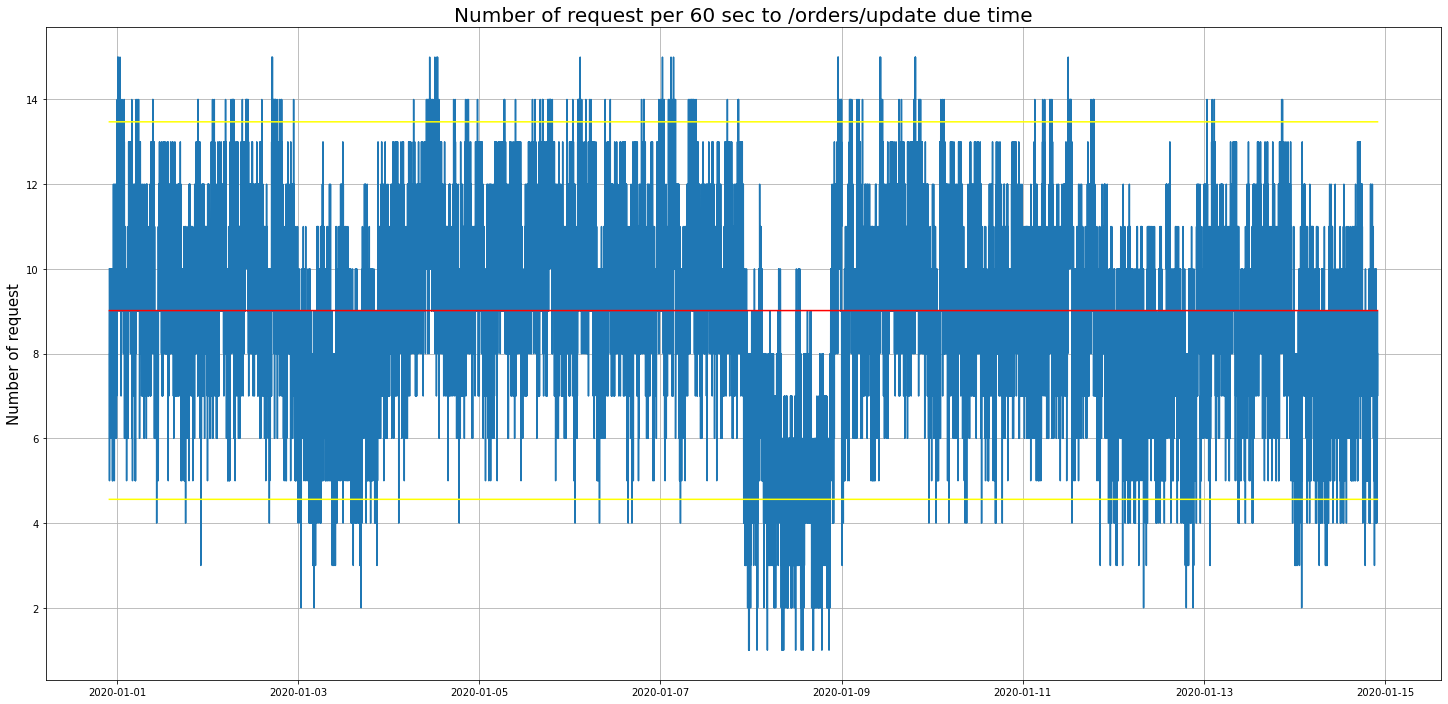

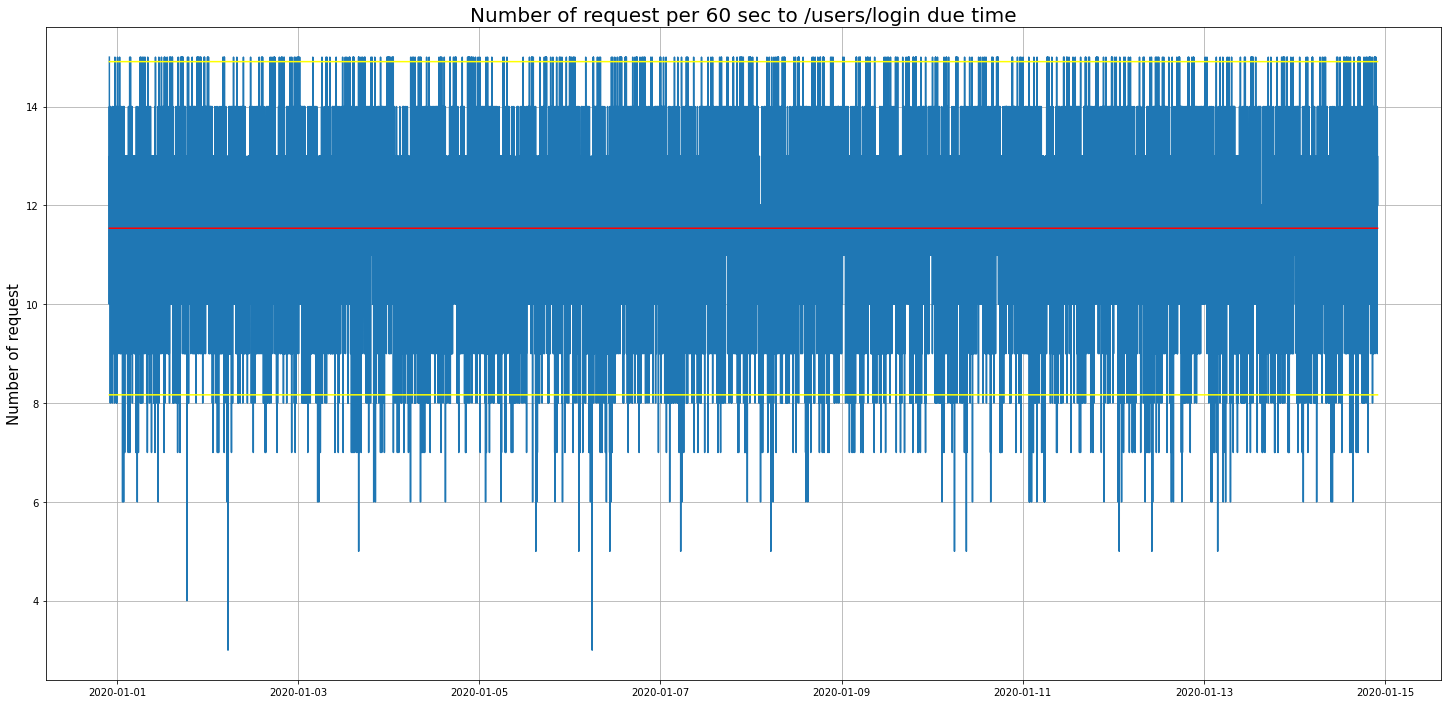

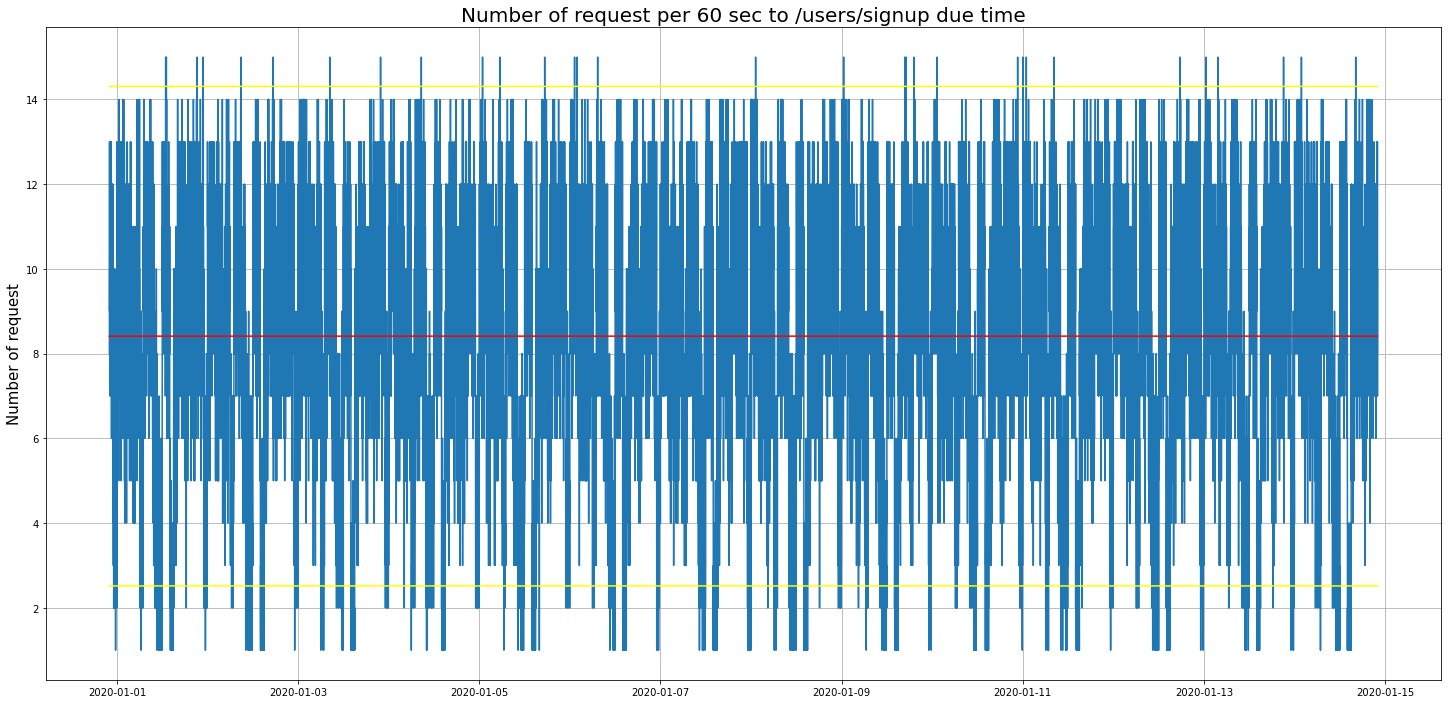

In [64]:
for route, route_data in rawdata.groupby('Route'):
    temp_agg_df = route_data.groupby('interval_window_60_sec')['User'].nunique().reset_index()
    temp_agg_df['time'] = pd.to_datetime(temp_agg_df.interval_window_60_sec, unit='s')
    temp_agg_df.sort_values(by='time', inplace=True)
    avrage_users = np.mean(temp_agg_df.User)
    std_users = np.std(temp_agg_df.User)
    plt.figure(figsize=(25,12))
    plt.grid()
    plt.plot(temp_agg_df.time, temp_agg_df.User)
    plt.plot(temp_agg_df.time, [avrage_users]*temp_agg_df.shape[0], color='red')
    plt.plot(temp_agg_df.time, [avrage_users+std_users*1.96]*temp_agg_df.shape[0], color='yellow')
    plt.plot(temp_agg_df.time, [avrage_users-std_users*1.96]*temp_agg_df.shape[0], color='yellow')
    plt.ylabel('Number of request', fontsize=15)
    plt.title(f'Number of request per 60 sec to {route} due time', fontsize=20)
    plt.show()

# Useres Analysis

### The number of request user commit 

<AxesSubplot:>

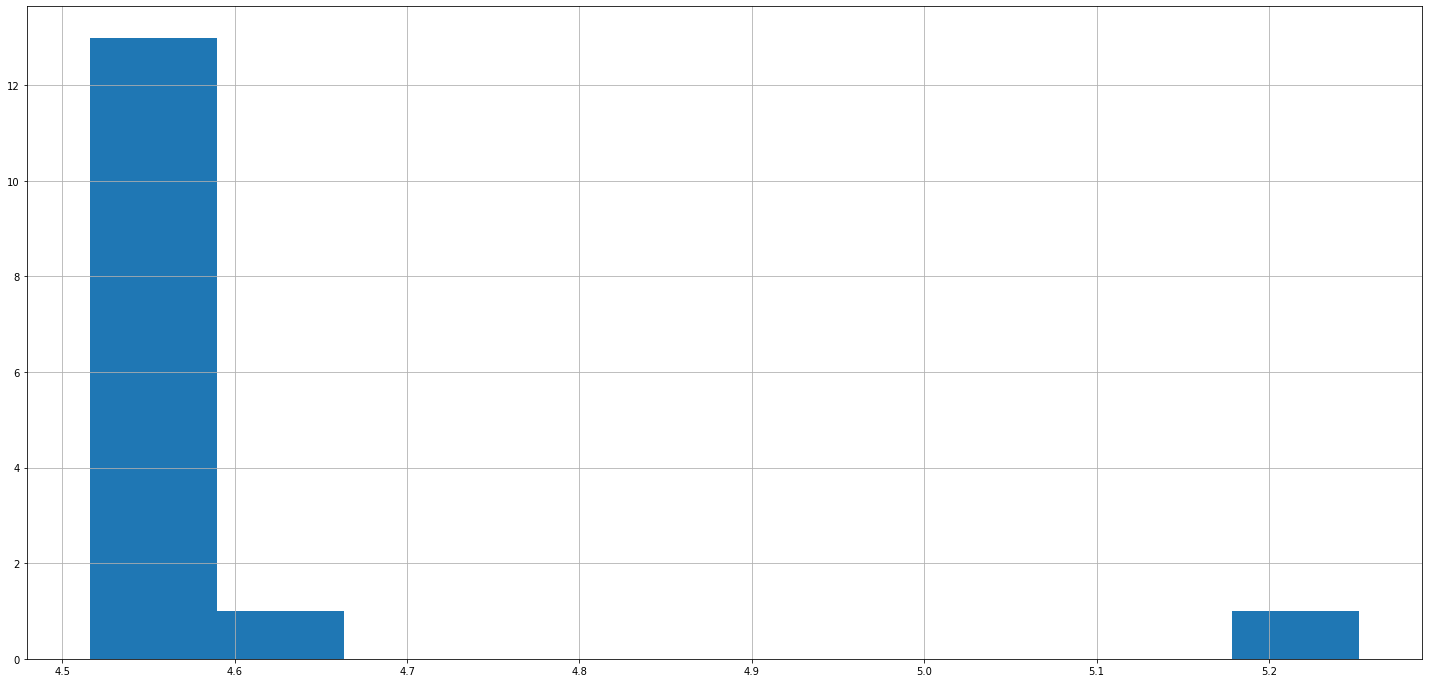

In [85]:
user_request_per_period = rawdata.groupby(by=['User', 'interval_window_60_sec']).size().rename('num_request').reset_index()
user_request_per_period = user_request_per_period.groupby('User')['num_request'].mean()
user_request_per_period.hist(
    figsize=(25,12)
)